In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

# Configuración para Jupyter Notebook
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Librerías importadas y configuración completada")

Librerías importadas y configuración completada


In [2]:
print("=== CARGA Y PREPROCESAMIENTO DE DATOS ===")

# Cargar datos
df_train = pd.read_csv('train.csv')
print(f"Datos cargados: {df_train.shape}")

# Preprocesamiento
df_processed = df_train.copy()
df_processed = df_processed.drop('id', axis=1)

# Mapear variables categóricas
cols_to_map = ['Stage_fear', 'Drained_after_socializing']
for col in cols_to_map:
    df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0})

# Codificar variable objetivo
le = LabelEncoder()
df_processed['Personality'] = le.fit_transform(df_processed['Personality'])

# Imputar valores faltantes
for column in df_processed.columns:
    if df_processed[column].isnull().any():
        median_value = df_processed[column].median()
        df_processed[column] = df_processed[column].fillna(median_value)

print("Preprocesamiento completado")
print(f"Forma final: {df_processed.shape}")

=== CARGA Y PREPROCESAMIENTO DE DATOS ===
Datos cargados: (18524, 9)
Preprocesamiento completado
Forma final: (18524, 8)



=== ANÁLISIS EXPLORATORIO ===
Distribución de clases:
Personality
0    13699
1     4825
Name: count, dtype: int64


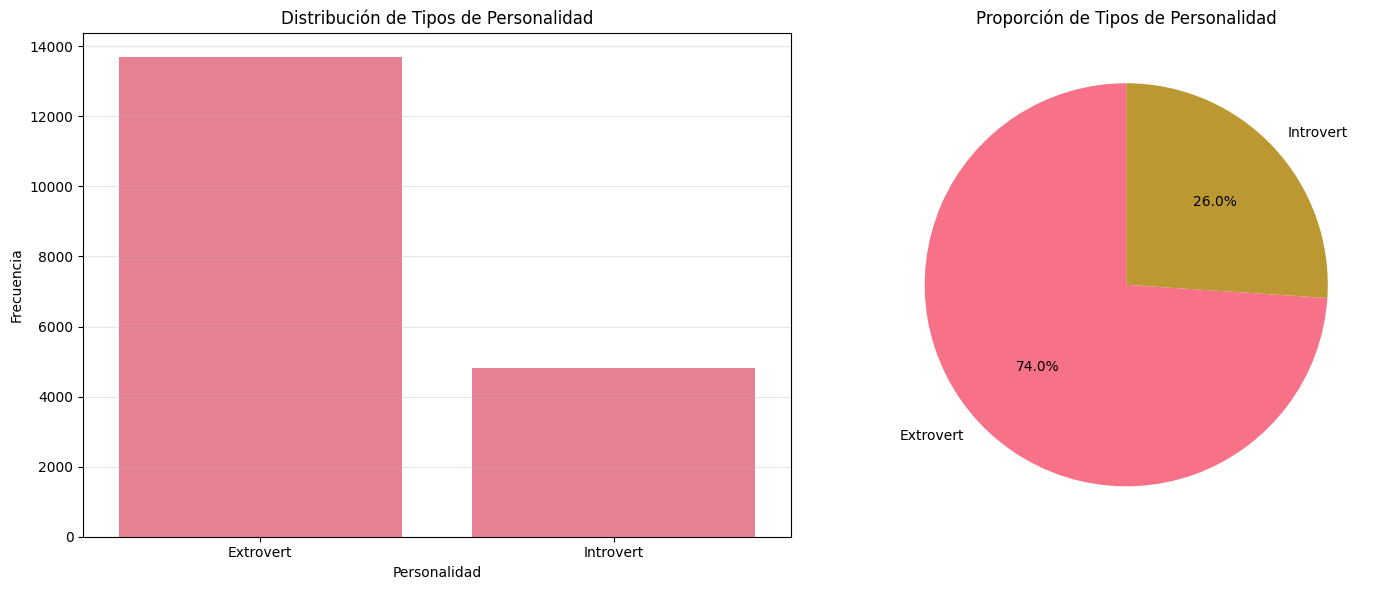


Estadísticas descriptivas:
       Time_spent_Alone    Stage_fear  Social_event_attendance  Going_outside  \
count      18524.000000  18524.000000             18524.000000   18524.000000   
mean           3.064673      0.217124                 5.248219       4.040812   
std            2.919057      0.412299                 2.665002       1.979312   
min            0.000000      0.000000                 0.000000       0.000000   
25%            1.000000      0.000000                 3.000000       3.000000   
50%            2.000000      0.000000                 5.000000       4.000000   
75%            4.000000      0.000000                 7.000000       6.000000   
max           11.000000      1.000000                10.000000       7.000000   

       Drained_after_socializing  Friends_circle_size  Post_frequency  \
count               18524.000000         18524.000000    18524.000000   
mean                    0.219283             7.996923        4.983319   
std                    

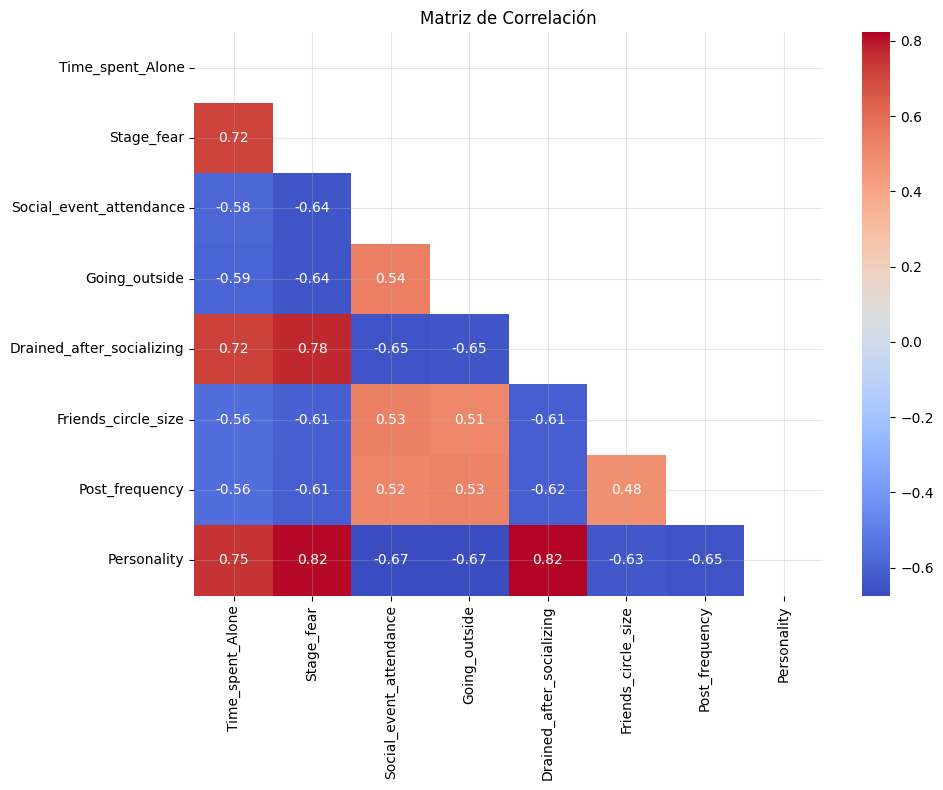

In [3]:
print("\n=== ANÁLISIS EXPLORATORIO ===")

# Distribución de clases
print("Distribución de clases:")
print(df_processed['Personality'].value_counts())

# Visualizar distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
sns.countplot(data=df_processed, x='Personality', ax=ax1)
ax1.set_title('Distribución de Tipos de Personalidad')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(le.classes_)
ax1.set_xlabel('Personalidad')
ax1.set_ylabel('Frecuencia')

# Gráfico de pie
personality_counts = df_processed['Personality'].value_counts()
ax2.pie(personality_counts.values, labels=le.classes_, autopct='%1.1f%%', startangle=90)
ax2.set_title('Proporción de Tipos de Personalidad')

plt.tight_layout()
plt.show()

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df_processed.describe())

# Matriz de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df_processed.corr(), dtype=bool))
sns.heatmap(df_processed.corr(), annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

In [4]:
X = df_processed.drop('Personality', axis=1)
y = df_processed['Personality']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Proporción de clases en train: {y_train.value_counts(normalize=True)}")
print(f"Proporción de clases en test: {y_test.value_counts(normalize=True)}")


Tamaño de X_train: (14819, 7)
Tamaño de X_test: (3705, 7)
Proporción de clases en train: Personality
0    0.739524
1    0.260476
Name: proportion, dtype: float64
Proporción de clases en test: Personality
0    0.739541
1    0.260459
Name: proportion, dtype: float64


In [5]:
print("\n=== MODELO BÁSICO DE REGRESIÓN LOGÍSTICA ===")

# Crear y entrenar modelo
lr_basic = LogisticRegression(random_state=42, max_iter=1000)
lr_basic.fit(X_train, y_train)

# Predicciones
y_pred_basic = lr_basic.predict(X_test)
y_pred_proba_basic = lr_basic.predict_proba(X_test)[:, 1]

# Evaluación
accuracy_basic = accuracy_score(y_test, y_pred_basic)
auc_basic = roc_auc_score(y_test, y_pred_proba_basic)

print(f"Accuracy: {accuracy_basic:.4f}")
print(f"AUC-ROC: {auc_basic:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_basic, target_names=['Extrovert', 'Introvert']))


=== MODELO BÁSICO DE REGRESIÓN LOGÍSTICA ===
Accuracy: 0.9717
AUC-ROC: 0.9576

Reporte de Clasificación:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



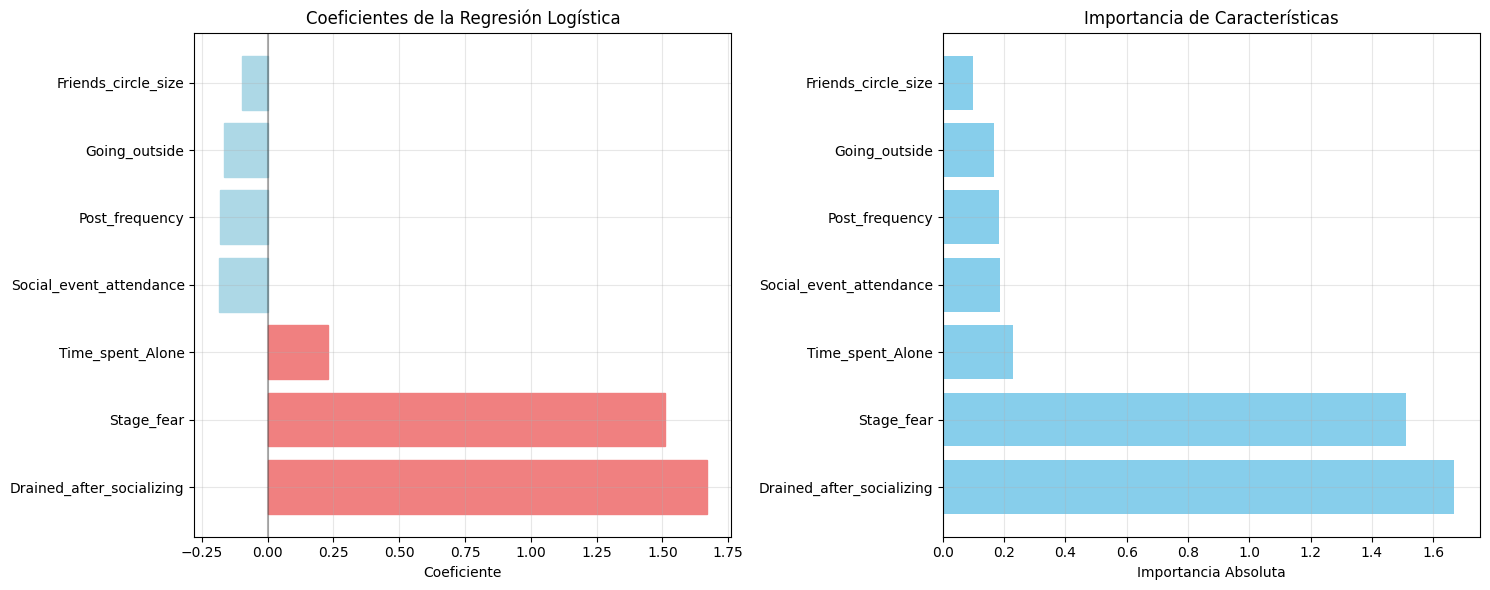


Coeficientes ordenados por importancia:
              Característica  Coeficiente  Absoluto
4  Drained_after_socializing     1.669461  1.669461
1                 Stage_fear     1.511607  1.511607
0           Time_spent_Alone     0.228480  0.228480
2    Social_event_attendance    -0.186069  0.186069
6             Post_frequency    -0.182254  0.182254
3              Going_outside    -0.166824  0.166824
5        Friends_circle_size    -0.097129  0.097129


In [6]:
feature_names = X.columns
coefficients = lr_basic.coef_[0]

# Crear DataFrame con coeficientes
coef_df = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefficients,
    'Absoluto': np.abs(coefficients)
})
coef_df = coef_df.sort_values('Absoluto', ascending=False)

# Visualizar coeficientes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras horizontales
bars = ax1.barh(coef_df['Característica'], coef_df['Coeficiente'])
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.set_xlabel('Coeficiente')
ax1.set_title('Coeficientes de la Regresión Logística')

# Colorear barras positivas y negativas
for bar, coef in zip(bars, coef_df['Coeficiente']):
    if coef > 0:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightblue')

# Gráfico de importancia absoluta
ax2.barh(coef_df['Característica'], coef_df['Absoluto'], color='skyblue')
ax2.set_xlabel('Importancia Absoluta')
ax2.set_title('Importancia de Características')

plt.tight_layout()
plt.show()

print("\nCoeficientes ordenados por importancia:")
print(coef_df)

In [7]:
print("\n=== MODELO CON ESCALADO DE CARACTERÍSTICAS ===")

pipeline_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

pipeline_scaled.fit(X_train, y_train)

# Predicciones
y_pred_scaled = pipeline_scaled.predict(X_test)
y_pred_proba_scaled = pipeline_scaled.predict_proba(X_test)[:, 1]

# Evaluación
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
auc_scaled = roc_auc_score(y_test, y_pred_proba_scaled)

print(f"Accuracy: {accuracy_scaled:.4f}")
print(f"AUC-ROC: {auc_scaled:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_scaled, target_names=['Extrovert', 'Introvert']))


=== MODELO CON ESCALADO DE CARACTERÍSTICAS ===
Accuracy: 0.9714
AUC-ROC: 0.9576

Reporte de Clasificación:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [8]:
print("\n=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===")

# Definir parámetros a optimizar
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Pipeline para optimización
pipeline_opt = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# GridSearchCV
grid_search = GridSearchCV(
    pipeline_opt,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor score CV: {grid_search.best_score_:.4f}")

# Evaluar el mejor modelo
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)
y_pred_proba_optimized = best_model.predict_proba(X_test)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

print(f"\nAccuracy del modelo optimizado: {accuracy_optimized:.4f}")
print(f"AUC-ROC del modelo optimizado: {auc_optimized:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_optimized, target_names=['Extrovert', 'Introvert']))


=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Mejores parámetros: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Mejor score CV: 0.9682

Accuracy del modelo optimizado: 0.9714
AUC-ROC del modelo optimizado: 0.9570

Reporte de Clasificación:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705




=== COMPARACIÓN DE MODELOS ===
         Modelo  Accuracy   AUC-ROC
0        Básico   0.97166  0.957583
1  Con Escalado   0.97139  0.957559
2    Optimizado   0.97139  0.956966


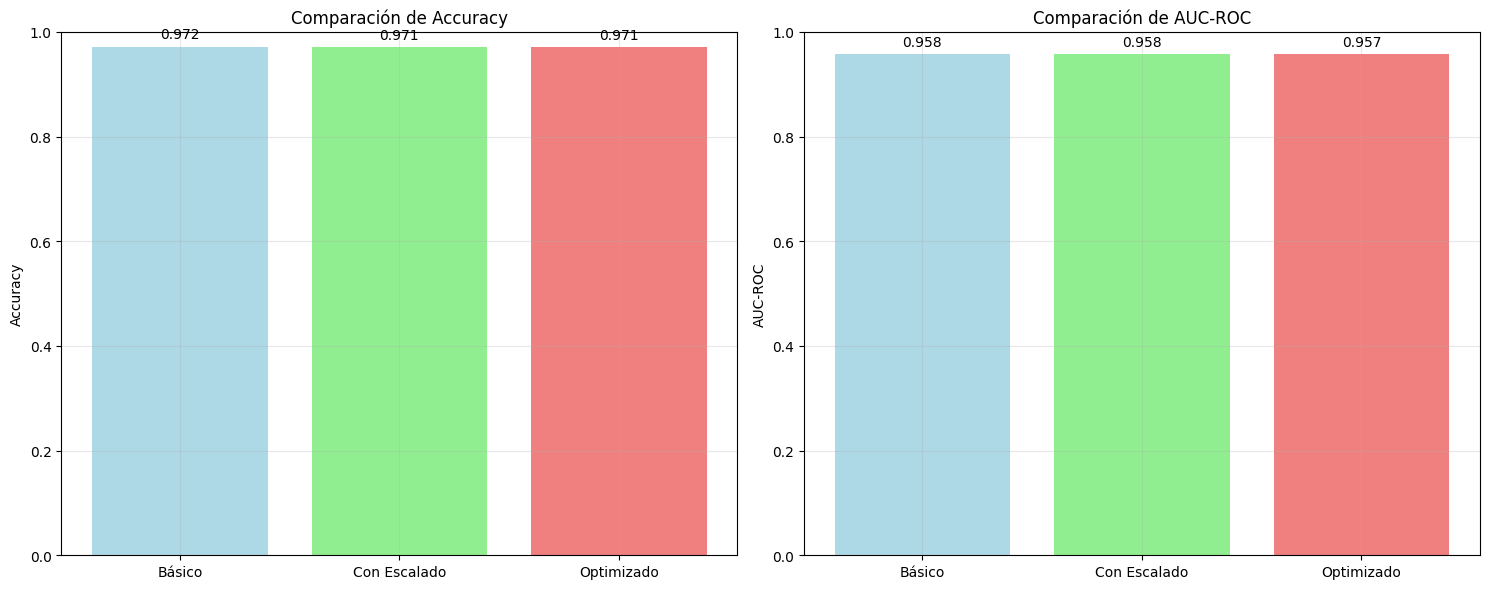

In [9]:
print("\n=== COMPARACIÓN DE MODELOS ===")

results = {
    'Modelo': ['Básico', 'Con Escalado', 'Optimizado'],
    'Accuracy': [accuracy_basic, accuracy_scaled, accuracy_optimized],
    'AUC-ROC': [auc_basic, auc_scaled, auc_optimized]
}

results_df = pd.DataFrame(results)
print(results_df)

# Visualizar comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy
bars1 = ax1.bar(results_df['Modelo'], results_df['Accuracy'], color=['lightblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Comparación de Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

# AUC-ROC
bars2 = ax2.bar(results_df['Modelo'], results_df['AUC-ROC'], color=['lightblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Comparación de AUC-ROC')
ax2.set_ylabel('AUC-ROC')
ax2.set_ylim(0, 1)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


=== CURVA ROC Y MATRIZ DE CONFUSIÓN ===


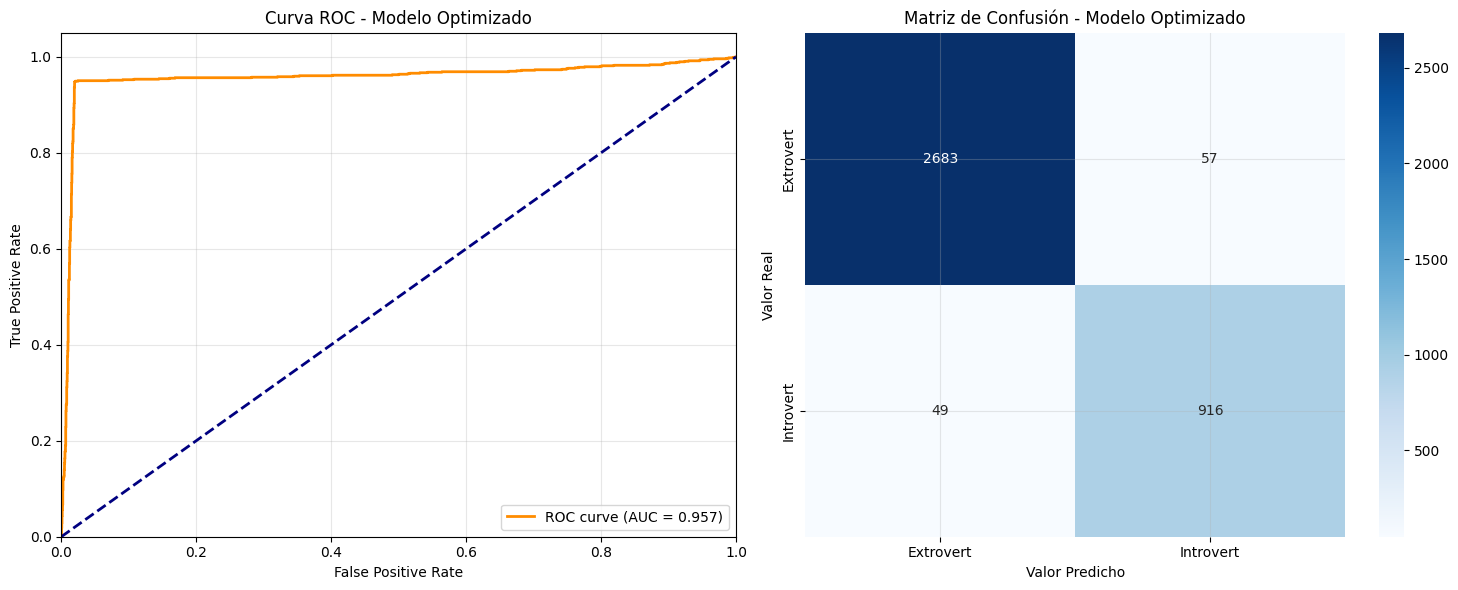

In [10]:
print("\n=== CURVA ROC Y MATRIZ DE CONFUSIÓN ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_optimized:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Curva ROC - Modelo Optimizado')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Extrovert', 'Introvert'], 
            yticklabels=['Extrovert', 'Introvert'], ax=ax2)
ax2.set_title('Matriz de Confusión - Modelo Optimizado')
ax2.set_ylabel('Valor Real')
ax2.set_xlabel('Valor Predicho')

plt.tight_layout()
plt.show()


=== ANÁLISIS DE INTERPRETABILIDAD ===
Análisis de coeficientes:
              Característica  Coeficiente  Absoluto  Odds Ratio
4  Drained_after_socializing     0.528513  0.528513    1.696408
1                 Stage_fear     0.509797  0.509797    1.664953
0           Time_spent_Alone     0.438765  0.438765    1.550791
2    Social_event_attendance    -0.317185  0.317185    0.728196
3              Going_outside    -0.308191  0.308191    0.734775
6             Post_frequency    -0.300539  0.300539    0.740419
5        Friends_circle_size    -0.277282  0.277282    0.757841


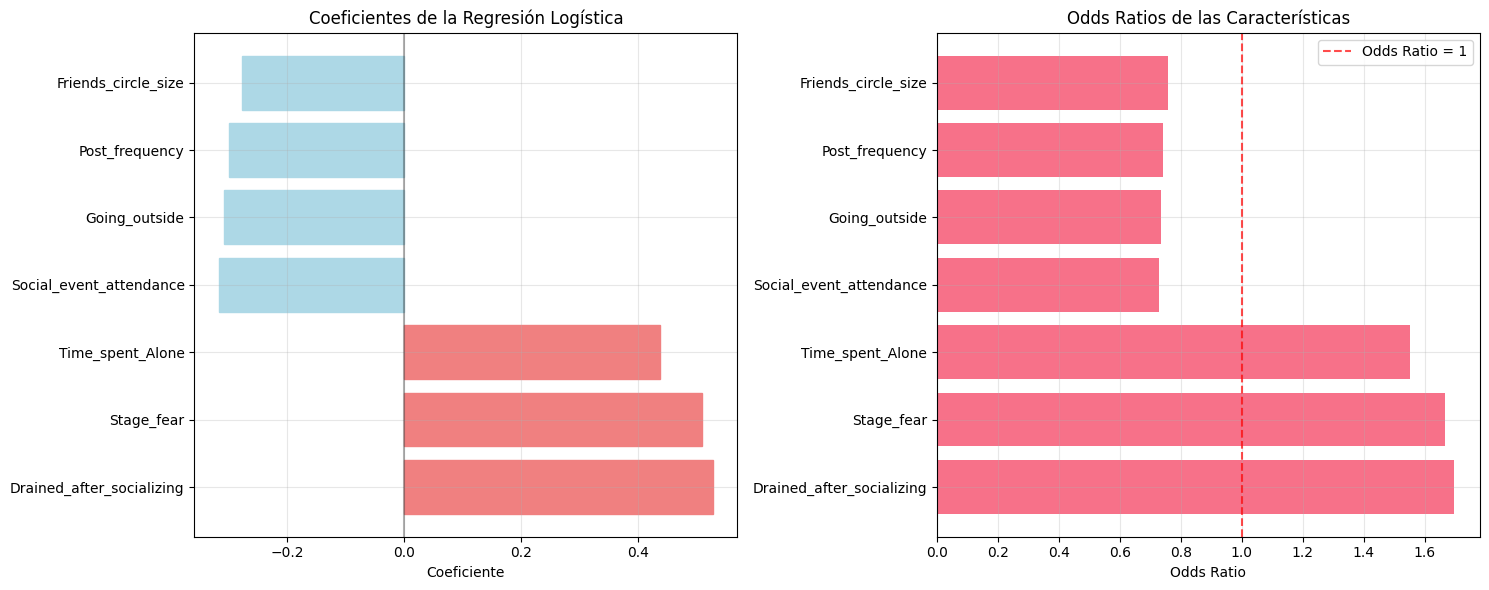


Interpretación:
- Odds Ratio > 1: Aumenta la probabilidad de ser introvertido
- Odds Ratio < 1: Disminuye la probabilidad de ser introvertido


In [11]:
print("\n=== ANÁLISIS DE INTERPRETABILIDAD ===")

# Obtener coeficientes del mejor modelo
best_classifier = best_model.named_steps['classifier']
feature_names = X.columns
coefficients = best_classifier.coef_[0]

# Crear DataFrame con coeficientes
coef_analysis = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefficients,
    'Absoluto': np.abs(coefficients),
    'Odds Ratio': np.exp(coefficients)
})
coef_analysis = coef_analysis.sort_values('Absoluto', ascending=False)

print("Análisis de coeficientes:")
print(coef_analysis)

# Visualizar coeficientes y odds ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Coeficientes
bars1 = ax1.barh(coef_analysis['Característica'], coef_analysis['Coeficiente'])
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.set_xlabel('Coeficiente')
ax1.set_title('Coeficientes de la Regresión Logística')

# Colorear barras positivas y negativas
for bar, coef in zip(bars1, coef_analysis['Coeficiente']):
    if coef > 0:
        bar.set_color('lightcoral')
    else:
        bar.set_color('lightblue')

# Odds ratios
bars2 = ax2.barh(coef_analysis['Característica'], coef_analysis['Odds Ratio'])
ax2.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='Odds Ratio = 1')
ax2.set_xlabel('Odds Ratio')
ax2.set_title('Odds Ratios de las Características')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Odds Ratio > 1: Aumenta la probabilidad de ser introvertido")
print("- Odds Ratio < 1: Disminuye la probabilidad de ser introvertido")


=== PREDICCIONES EN DATASET DE TEST ===
Dataset de test procesado exitosamente
Forma del test set: (6175, 7)
Realizando predicciones...

Archivo 'submission_logistic_regression.csv' creado exitosamente
Número de predicciones: 6175
Distribución de predicciones:
Personality
Extrovert    4613
Introvert    1562
Name: count, dtype: int64


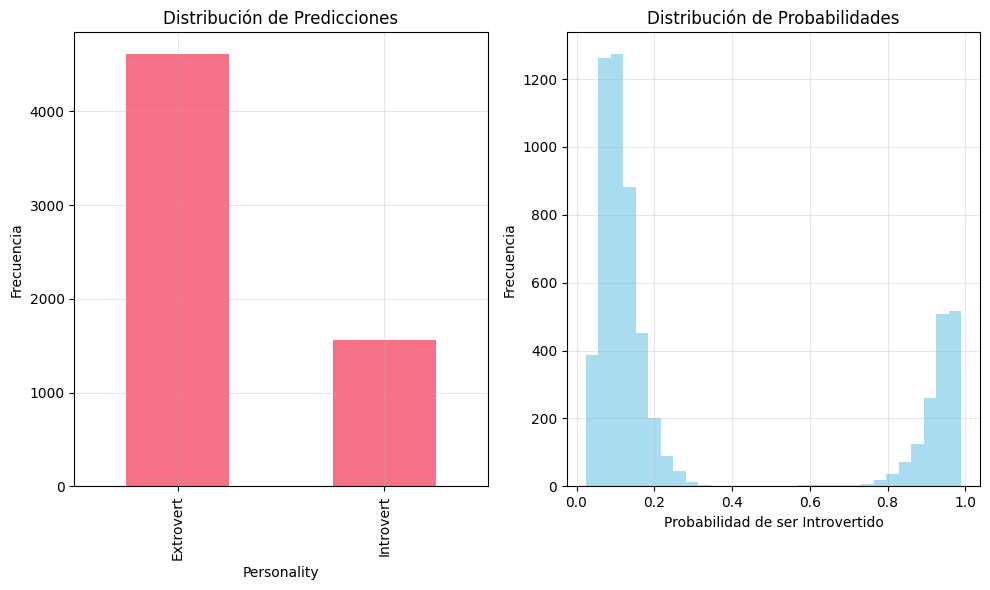

In [12]:
print("\n=== PREDICCIONES EN DATASET DE TEST ===")

# Cargar y procesar el dataset de test
df_test = pd.read_csv('test.csv')
test_ids = df_test['id']

# Aplicar el mismo preprocesamiento
df_test_processed = df_test.copy()
df_test_processed = df_test_processed.drop('id', axis=1)

# Mapear variables categóricas
cols_to_map = ['Stage_fear', 'Drained_after_socializing']
for col in cols_to_map:
    df_test_processed[col] = df_test_processed[col].map({'Yes': 1, 'No': 0})

# Imputar valores faltantes usando la mediana del set de entrenamiento
for column in df_test_processed.columns:
    if df_test_processed[column].isnull().any():
        median_value = X[column].median()
        df_test_processed[column] = df_test_processed[column].fillna(median_value)

print("Dataset de test procesado exitosamente")
print(f"Forma del test set: {df_test_processed.shape}")

# Realizar predicciones
print("Realizando predicciones...")
test_predictions = best_model.predict(df_test_processed)
test_probabilities = best_model.predict_proba(df_test_processed)[:, 1]

# Convertir predicciones a etiquetas originales
final_predictions_labels = le.inverse_transform(test_predictions)

# Crear archivo de submission
submission_df = pd.DataFrame({
    'id': test_ids,
    'Personality': final_predictions_labels
})

# Guardar submission
submission_df.to_csv('submission_logistic_regression.csv', index=False)
print("\nArchivo 'submission_logistic_regression.csv' creado exitosamente")
print(f"Número de predicciones: {len(submission_df)}")
print(f"Distribución de predicciones:")
print(submission_df['Personality'].value_counts())

# Visualizar distribución de predicciones
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
submission_df['Personality'].value_counts().plot(kind='bar')
plt.title('Distribución de Predicciones')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(test_probabilities, bins=30, alpha=0.7, color='skyblue')
plt.title('Distribución de Probabilidades')
plt.xlabel('Probabilidad de ser Introvertido')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [13]:
print("\n=== RESUMEN FINAL ===")
print(f"Mejor modelo - Accuracy: {accuracy_optimized:.4f}")
print(f"Mejor modelo - AUC-ROC: {auc_optimized:.4f}")
print("\nVentajas del modelo de regresión logística:")
print("1. Interpretabilidad: Los coeficientes son fáciles de entender")
print("2. Eficiencia: Entrenamiento rápido")
print("3. Probabilidades: Proporciona probabilidades de pertenencia a cada clase")
print("4. Estabilidad: Menos propenso al overfitting")

print("\nArchivo de submission creado: 'submission_logistic_regression.csv'")


=== RESUMEN FINAL ===
Mejor modelo - Accuracy: 0.9714
Mejor modelo - AUC-ROC: 0.9570

Ventajas del modelo de regresión logística:
1. Interpretabilidad: Los coeficientes son fáciles de entender
2. Eficiencia: Entrenamiento rápido
3. Probabilidades: Proporciona probabilidades de pertenencia a cada clase
4. Estabilidad: Menos propenso al overfitting

Archivo de submission creado: 'submission_logistic_regression.csv'
